In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, linregress

import os
import time
import itertools

from glove.model3 import *

from sklearn.model_selection import KFold

In [2]:
# number of folds
n_splits = 20

# import file names
files = os.listdir("data/SET3_Thirdtrial/")

# fit gLV models

In [3]:
def predict_df(df, species):
    
    # save measured and predicted values
    exp_names = []
    pred_species = []
    pred = []
    stdv = []
    true = []

    # pull just the community data
    test_data = process_df(df, species) 

    # plot the results
    for exp, t_span, Y_m in test_data:

        # predict 
        Y_p, Y_std = model.predict(Y_m, t_span)
        
        # set NaN to zero
        Y_p = np.nan_to_num(Y_p)
        Y_std = np.nan_to_num(Y_std)
        
        ### prediction results for species that were present ###
        inds_present = Y_m[0] > 0 
        exp_names.append([exp]*sum(inds_present)*(Y_m.shape[0]-1))
        pred_species.append(np.tile(np.vstack(species)[inds_present], Y_m.shape[0]-1).T.ravel())
        true.append(Y_m[1:,inds_present].ravel())
        pred.append(Y_p[1:,inds_present].ravel())
        stdv.append(Y_std[1:,inds_present].ravel())
                
    # concatenate list
    exp_names = np.concatenate(exp_names)
    pred_species = np.concatenate(pred_species)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    stdv = np.concatenate(stdv)
        
    return exp_names, pred_species, true, pred, stdv

In [ ]:
# run kfold for each file 
for file in files:
    strain = file.split("_")[0]
    
    # import data
    df = pd.read_csv(f"data/SET3_Thirdtrial/{file}")
    df.sort_values(by=["Treatments", "Time"], inplace=True)
    
    # make sure that conditions have at least one measurement
    dfs = []
    for treatment, df_t in df.groupby("Treatments"):
        if df_t.shape[0] > 1:
            dfs.append(df_t)
    df = pd.concat(dfs)

    # determine species names 
    species = df.columns.values[2:]

    # separate mono culture data 
    mono_dfs = []
    dfs = []
    treatments = []
    for treatment, df_i in df.groupby("Treatments"):
        # hyphen is only in community conditions
        if "-" in treatment:
            dfs.append(df_i)
            # save treatment name without the replicate identifier 
            treatments.append([treatment.split("_")[0]]*df_i.shape[0])
        else:
            mono_dfs.append(df_i)
    treatments = np.concatenate(treatments)
    unique_treatments = np.unique(treatments)
    mono_df = pd.concat(mono_dfs)
    df = pd.concat(dfs)

    # init kfold object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=21)

    # keep track of all predictions
    all_exp_names = []
    all_pred_species = []
    all_true = []
    all_pred = []
    all_stdv = []

    # run Kfold 
    for train_index, test_index in kf.split(unique_treatments):
        
        # get train df
        train_inds = np.in1d(treatments, unique_treatments[train_index])
        train_df = df.iloc[train_inds].copy()
        train_df = pd.concat((mono_df, train_df))
        
        # average replicates in the test_df
        test_df = []
        for test_treatment in unique_treatments[test_index]:
            # pull dataframe with all replicates of same test treatment 
            treatment_inds = np.in1d(treatments, test_treatment)
            df_treatment = df.iloc[treatment_inds].copy()
            
            # get set of unique measurement times
            treatment_times = np.unique(df_treatment.Time.values)
            
            # init dataframe to store averaged values
            avg_df = pd.DataFrame()
            avg_df['Treatments'] = [test_treatment]*len(treatment_times)
            avg_df['Time'] = treatment_times

            avg_data = np.zeros([len(treatment_times), len(species)])
            for i, time in enumerate(treatment_times):
                avg_data[i] = df_treatment.iloc[df_treatment.Time.values==time][species].mean()
            avg_df[species] = avg_data
            test_df.append(avg_df)
        
        # combine averaged dataframes for test dataframe
        test_df = pd.concat(test_df)
        
        # instantiate gLV fit 
        model = gLV(species, train_df)

        # fit to data 
        model.fit()

        # predict test data
        exp_names, pred_species, true, pred, stdv = predict_df(test_df, species)

        # append predictions 
        all_exp_names = np.append(all_exp_names, exp_names)
        all_pred_species = np.append(all_pred_species, pred_species)
        all_true = np.append(all_true, true)
        all_pred = np.append(all_pred, pred)
        all_stdv = np.append(all_stdv, stdv)

        # save prediction results to a .csv
        kfold_df = pd.DataFrame()
        kfold_df['Treatments'] = all_exp_names
        kfold_df['species'] = all_pred_species
        kfold_df['true'] = all_true
        kfold_df['pred'] = all_pred
        kfold_df['stdv'] = all_stdv
        kfold_df.to_csv(f"kfold/{strain}_{n_splits}_fold_3.csv", index=False)
        
    # show prediction performance of individual species
    for sp in species:
        sp_inds = all_pred_species == sp
        R = linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue
        plt.scatter(all_true[sp_inds], all_pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))
        plt.errorbar(all_true[sp_inds], all_pred[sp_inds], yerr=all_stdv[sp_inds], 
                     fmt='.', capsize=3)

    plt.xlabel("Measured OD")
    plt.ylabel("Predicted OD")
    plt.legend()
    plt.title(strain)
    plt.savefig(f"figures/{strain}_{n_splits}_fold_3.pdf", dpi=300)
    plt.show()

Total samples: 258, Initial regularization: 1.00e-03
Loss: 29.841, Residuals: -0.336
Loss: 15.817, Residuals: 0.189
Loss: 12.964, Residuals: 0.130
Loss: 8.996, Residuals: 0.081
Loss: 6.675, Residuals: 0.055
Loss: 6.153, Residuals: 0.041
Loss: 5.696, Residuals: 0.033
Loss: 5.511, Residuals: 0.043
Loss: 5.186, Residuals: 0.038
Loss: 4.870, Residuals: 0.029
Loss: 4.861, Residuals: 0.036
Loss: 4.770, Residuals: 0.034
Loss: 4.605, Residuals: 0.028
Loss: 4.491, Residuals: 0.045
Loss: 4.476, Residuals: 0.048
Loss: 4.349, Residuals: 0.040
Loss: 4.155, Residuals: 0.025
Loss: 4.149, Residuals: 0.027
Loss: 4.142, Residuals: 0.030
Loss: 4.070, Residuals: 0.026
Loss: 4.053, Residuals: 0.029
Loss: 4.020, Residuals: 0.027
Loss: 4.017, Residuals: 0.030
Loss: 3.911, Residuals: 0.023
Loss: 3.909, Residuals: 0.024
Loss: 3.908, Residuals: 0.028
Loss: 3.856, Residuals: 0.024
Loss: 3.856, Residuals: 0.024
Loss: 3.789, Residuals: 0.020
Loss: 3.788, Residuals: 0.020
Loss: 3.785, Residuals: 0.020
Loss: 3.782, 

Evidence 3489.953
Updating hyper-parameters...
Total samples: 254, Updated regularization: 3.44e-01
Loss: 761.002, Residuals: 0.014
Optimization terminated successfully.
Evidence 4613.064
Updating hyper-parameters...
Total samples: 254, Updated regularization: 3.84e-01
Loss: 966.418, Residuals: 0.019
Loss: 964.868, Residuals: 0.011
Optimization terminated successfully.
Evidence 4690.971
Updating hyper-parameters...
Total samples: 254, Updated regularization: 3.91e-01
Loss: 1003.362, Residuals: 0.008
Loss: 994.768, Residuals: 0.009
Loss: 983.484, Residuals: 0.010
Loss: 983.343, Residuals: 0.011
Optimization terminated successfully.
Evidence 4723.612
Updating hyper-parameters...
Total samples: 254, Updated regularization: 3.90e-01
Loss: 996.778, Residuals: 0.015
Loss: 995.874, Residuals: 0.013
Optimization terminated successfully.
Evidence 4739.794
Updating hyper-parameters...
Total samples: 254, Updated regularization: 3.87e-01
Loss: 1007.888, Residuals: 0.013
Loss: 997.444, Residuals: 

Evidence 4842.565
Updating hyper-parameters...
Total samples: 257, Updated regularization: 3.91e-01
Loss: 1002.598, Residuals: 0.014
Loss: 1001.902, Residuals: 0.013
Optimization terminated successfully.
Evidence 4862.577
Updating hyper-parameters...
Total samples: 257, Updated regularization: 3.36e-01
Loss: 1020.091, Residuals: 0.015
Optimization terminated successfully.
Evidence 4872.847
Updating hyper-parameters...
Total samples: 257, Updated regularization: 3.32e-01
Loss: 1017.834, Residuals: 0.015
Loss: 1017.658, Residuals: 0.015
Optimization terminated successfully.
Evidence 4878.484
Updating hyper-parameters...
Total samples: 257, Updated regularization: 3.30e-01
Loss: 1021.260, Residuals: 0.014
Loss: 1020.184, Residuals: 0.015
Loss: 1011.055, Residuals: 0.014
Loss: 1011.000, Residuals: 0.015
Optimization terminated successfully.
Evidence 4891.368
Updating hyper-parameters...
Total samples: 257, Updated regularization: 2.96e-01
Loss: 1022.334, Residuals: 0.015
Optimization termi

Loss: 4.619, Residuals: 0.022
Loss: 4.617, Residuals: 0.022
Loss: 4.545, Residuals: 0.018
Loss: 4.545, Residuals: 0.018
Optimization terminated successfully.
Evidence -79.304
Updating hyper-parameters...
Total samples: 256, Updated regularization: 4.88e-01
Loss: 187.591, Residuals: 0.014
Optimization terminated successfully.
Evidence 3537.717
Updating hyper-parameters...
Total samples: 256, Updated regularization: 4.17e-01
Loss: 773.307, Residuals: 0.015
Optimization terminated successfully.
Evidence 4655.958
Updating hyper-parameters...
Total samples: 256, Updated regularization: 4.67e-01
Loss: 973.901, Residuals: 0.010
Loss: 965.901, Residuals: 0.011
Loss: 953.799, Residuals: 0.012
Loss: 952.995, Residuals: 0.014
Loss: 945.538, Residuals: 0.014
Loss: 934.108, Residuals: 0.017
Loss: 934.048, Residuals: 0.017
Optimization terminated successfully.
Evidence 4767.808
Updating hyper-parameters...
Total samples: 256, Updated regularization: 4.63e-01
Loss: 1011.856, Residuals: 0.017
Optimiza

Loss: 1024.126, Residuals: 0.014
Loss: 1013.648, Residuals: 0.012
Loss: 1010.624, Residuals: 0.014
Loss: 1010.455, Residuals: 0.014
Optimization terminated successfully.
Evidence 4913.102
Updating hyper-parameters...
Total samples: 258, Updated regularization: 3.56e-01
Loss: 1024.272, Residuals: 0.014
Loss: 1017.849, Residuals: 0.013
Loss: 1017.796, Residuals: 0.013
Optimization terminated successfully.
Evidence 4924.142
Updating hyper-parameters...
Total samples: 258, Updated regularization: 3.37e-01
Loss: 1013.813, Residuals: 0.011
Loss: 1013.336, Residuals: 0.011
Optimization terminated successfully.
Evidence 4937.361
Updating hyper-parameters...
Total samples: 258, Updated regularization: 2.71e-01
Loss: 1025.736, Residuals: 0.014
Optimization terminated successfully.
Evidence 4943.688
Updating hyper-parameters...
Total samples: 258, Updated regularization: 2.67e-01
Loss: 1026.778, Residuals: 0.013
Loss: 1025.927, Residuals: 0.013
Loss: 1019.516, Residuals: 0.012
Loss: 1019.490, Res

Loss: 17.467, Residuals: 0.210
Loss: 14.168, Residuals: 0.146
Loss: 9.743, Residuals: 0.083
Loss: 7.614, Residuals: 0.057
Loss: 7.171, Residuals: 0.035
Loss: 6.843, Residuals: 0.036
Loss: 6.374, Residuals: 0.042
Loss: 5.988, Residuals: 0.025
Loss: 5.964, Residuals: 0.033
Loss: 5.749, Residuals: 0.027
Loss: 5.385, Residuals: 0.018
Loss: 5.367, Residuals: 0.029
Loss: 5.341, Residuals: 0.029
Loss: 5.202, Residuals: 0.025
Loss: 5.168, Residuals: 0.035
Loss: 5.104, Residuals: 0.032
Loss: 4.992, Residuals: 0.026
Loss: 4.984, Residuals: 0.028
Loss: 4.970, Residuals: 0.028
Loss: 4.845, Residuals: 0.021
Loss: 4.843, Residuals: 0.024
Loss: 4.828, Residuals: 0.024
Loss: 4.702, Residuals: 0.019
Loss: 4.699, Residuals: 0.024
Loss: 4.695, Residuals: 0.024
Loss: 4.687, Residuals: 0.023
Loss: 4.618, Residuals: 0.020
Loss: 4.617, Residuals: 0.021
Loss: 4.615, Residuals: 0.022
Loss: 4.610, Residuals: 0.022
Loss: 4.573, Residuals: 0.019
Loss: 4.572, Residuals: 0.022
Loss: 4.548, Residuals: 0.020
Loss: 4.

In [6]:
kfold_df = pd.read_csv(f"kfold/CDevo_20_fold_3.csv")

In [8]:
# import file names
files = os.listdir("data/SET3_Thirdtrial/")
file = files[0]

In [9]:
# import data
df = pd.read_csv(f"data/SET3_Thirdtrial/{file}")
df.sort_values(by=["Treatments", "Time"], inplace=True)

# make sure that conditions have at least one measurement
dfs = []
for treatment, df_t in df.groupby("Treatments"):
    if df_t.shape[0] > 1:
        dfs.append(df_t)
df = pd.concat(dfs)

# determine species names 
species = df.columns.values[2:]

NameError: name 'strain' is not defined

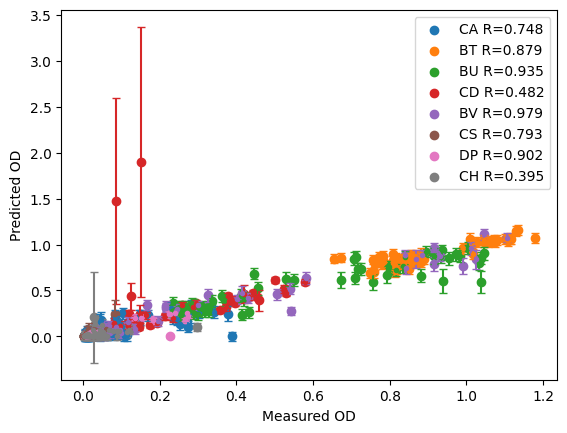

In [12]:
all_pred_species = kfold_df['species'].values
all_true  = kfold_df['true'].values
all_pred = kfold_df['pred'].values
all_stdv = kfold_df['stdv'].values

# show prediction performance of individual species
for sp in species:
    sp_inds = all_pred_species == sp
    R = linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue
    plt.scatter(all_true[sp_inds], all_pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))
    plt.errorbar(all_true[sp_inds], all_pred[sp_inds], yerr=all_stdv[sp_inds], 
                 fmt='.', capsize=3)

plt.xlabel("Measured OD")
plt.ylabel("Predicted OD")
plt.legend()
plt.title(strain)
# plt.savefig(f"figures/{strain}_{n_splits}_fold_3.pdf", dpi=300)
plt.show()